In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
# Starting Spark Session
spark = (SparkSession
         .builder
         .appName('SkinLesionsML')
         .config('spark.driver.memory', '2g')
         .getOrCreate()
         )

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/16 13:52:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/16 13:52:41 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# Ingesting meta data
meta_filename = './archive/HAM10000_metadata.csv'
meta_df = (spark.read.format('csv')
                 .option('header', 'true')
                 .option('inferSchema', 'true')
                 .load(meta_filename)
                 )
print(f'Has {meta_df.count()} rows...')
meta_df.show(n=10, truncate=False)

Has 10015 rows...
+---+-----------+------------+---+-------+----+------+------------+------+
|_c0|lesion_id  |image_id    |dx |dx_type|age |sex   |localization|threat|
+---+-----------+------------+---+-------+----+------+------------+------+
|0  |HAM_0000118|ISIC_0027419|bkl|histo  |80.0|male  |scalp       |benign|
|1  |HAM_0000118|ISIC_0025030|bkl|histo  |80.0|male  |scalp       |benign|
|2  |HAM_0002730|ISIC_0026769|bkl|histo  |80.0|male  |scalp       |benign|
|3  |HAM_0002730|ISIC_0025661|bkl|histo  |80.0|male  |scalp       |benign|
|4  |HAM_0001466|ISIC_0031633|bkl|histo  |75.0|male  |ear         |benign|
|5  |HAM_0001466|ISIC_0027850|bkl|histo  |75.0|male  |ear         |benign|
|6  |HAM_0002761|ISIC_0029176|bkl|histo  |60.0|male  |face        |benign|
|7  |HAM_0002761|ISIC_0029068|bkl|histo  |60.0|male  |face        |benign|
|8  |HAM_0005132|ISIC_0025837|bkl|histo  |70.0|female|back        |benign|
|9  |HAM_0005132|ISIC_0025209|bkl|histo  |70.0|female|back        |benign|
+---+--

23/12/16 13:52:46 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , lesion_id, image_id, dx, dx_type, age, sex, localization, threat
 Schema: _c0, lesion_id, image_id, dx, dx_type, age, sex, localization, threat
Expected: _c0 but found: 
CSV file: file:///Users/christianrivera/Documents/Academic/MSML/MSML651/project/archive/HAM10000_metadata.csv


In [4]:
# Preparing bar plot
def plot_bar(X, Y, title, xlabel, ylabel, rotate=False):
    plt.bar(X, Y)
    if rotate:
        plt.xticks(rotation=90)
    plt.xlabel(xlabel) 
    plt.ylabel(ylabel) 
    plt.title(title)
    plt.grid('True')
    plt.show()

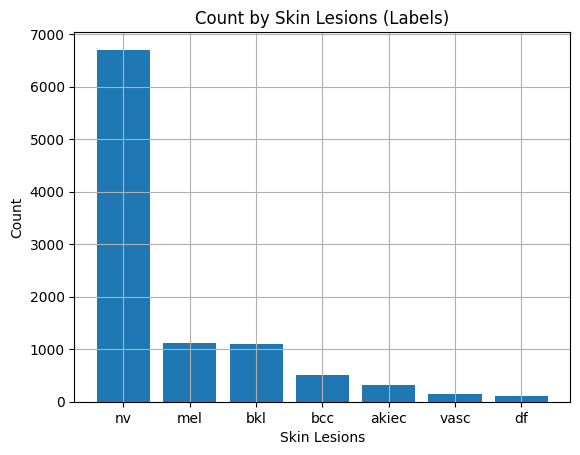

['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
[6705, 1113, 1099, 514, 327, 142, 115]


In [5]:
# Plotting types of skin lesions and their count
sl_df = meta_df.groupBy('dx').count().orderBy(F.col('count').desc())
X = [val.__getitem__('dx') for val in sl_df.select('dx').collect()]
Y = [val.__getitem__('count') for val in sl_df.select('count').collect()]
title = 'Count by Skin Lesions (Labels)'
plot_bar(X, Y, title, 'Skin Lesions', 'Count')
print(X)
print(Y)


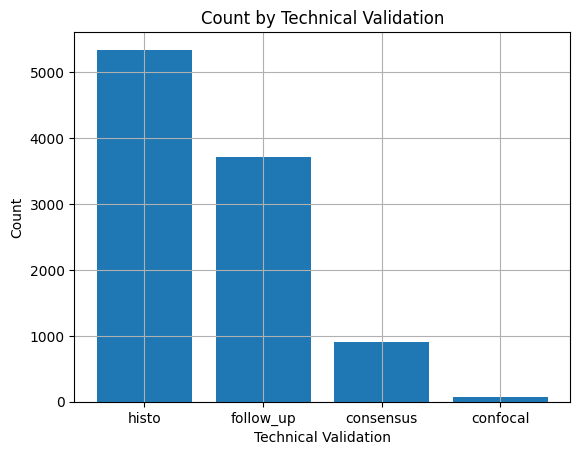

In [6]:
# Plotting types of technical validation and their count
tv_df = meta_df.groupBy('dx_type').count().orderBy(F.col('count').desc())
X = [val.__getitem__('dx_type') for val in tv_df.select('dx_type').collect()]
Y = [val.__getitem__('count') for val in tv_df.select('count').collect()]
title = 'Count by Technical Validation'
plot_bar(X, Y, title, 'Technical Validation', 'Count')

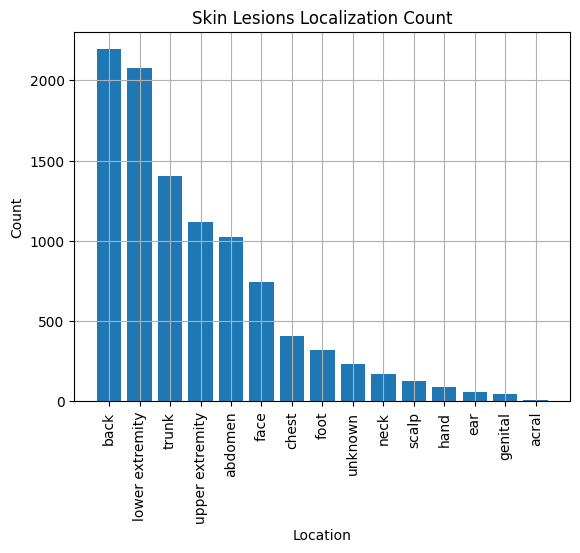

In [7]:
# Plotting different skin lesions localizations and their count
loc_df = meta_df.groupBy('localization').count().orderBy(F.col('count').desc())
X = [val.__getitem__('localization') for val in loc_df.select('localization').collect()]
Y = [val.__getitem__('count') for val in loc_df.select('count').collect()]
title = 'Skin Lesions Localization Count'
plot_bar(X, Y, title, 'Location', 'Count', rotate=True)

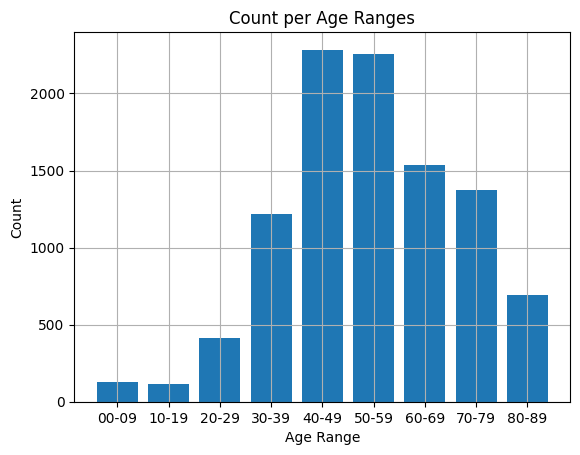

In [8]:
# Plotting by age range
avg_age = meta_df.select(F.avg(meta_df.age)).collect()[0].__getitem__('avg(age)')
meta_df = meta_df.fillna(round(avg_age), subset='age')
age_df = meta_df.withColumn(
    'age_range',
    F.when(F.col('age').between(0,9), '00-09')
    .when(F.col('age').between(10,19), '10-19')
    .when(F.col('age').between(20,29), '20-29')
    .when(F.col('age').between(30,39), '30-39')
    .when(F.col('age').between(40,49), '40-49')
    .when(F.col('age').between(50,59), '50-59')
    .when(F.col('age').between(60,69), '60-69')
    .when(F.col('age').between(70,79), '70-79')
    .when(F.col('age').between(80,89), '80-89')
).select('age_range').groupBy('age_range').count().orderBy(F.col('age_range'))

X = [val.__getitem__('age_range') for val in age_df.select('age_range').collect()]
Y = [val.__getitem__('count') for val in age_df.select('count').collect()]
title = 'Count per Age Ranges'
plot_bar(X, Y, title, 'Age Range', 'Count')

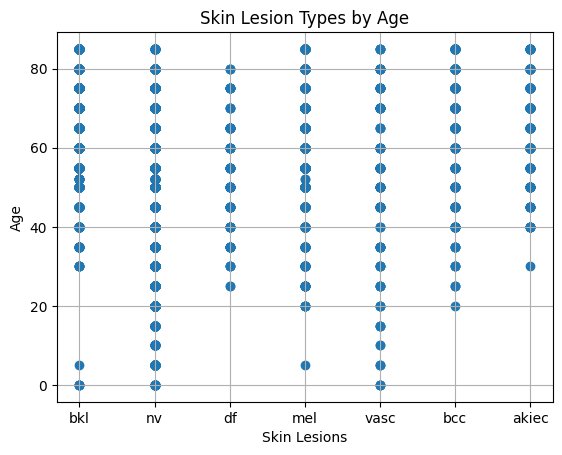

In [9]:
# Plotting type of skin lesions by age
X = [val.__getitem__('dx') for val in meta_df.select('dx').collect()]
Y = [val.__getitem__('age') for val in meta_df.select('age').collect()]

plt.scatter(X, Y)
plt.title('Skin Lesion Types by Age')
plt.xlabel("Skin Lesions") 
plt.ylabel("Age") 
plt.grid(True)
plt.show()

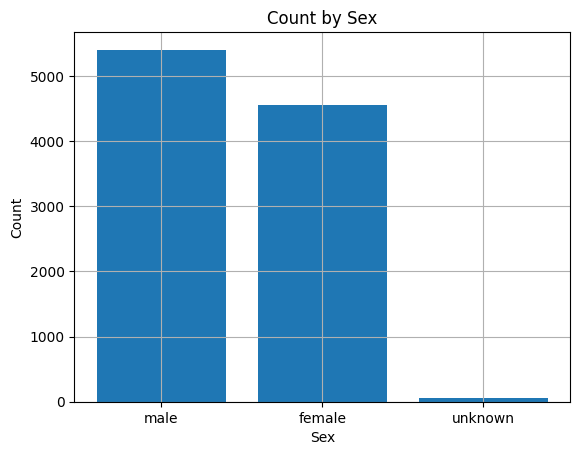

In [10]:
# Plotting by Sex Count
sex_df = meta_df.groupBy('sex').count().orderBy(F.col('count').desc())
X = [val.__getitem__('sex') for val in sex_df.select('sex').collect()]
Y = [val.__getitem__('count') for val in sex_df.select('count').collect()]
title = 'Count by Sex'
plot_bar(X, Y, title, 'Sex', 'Count')

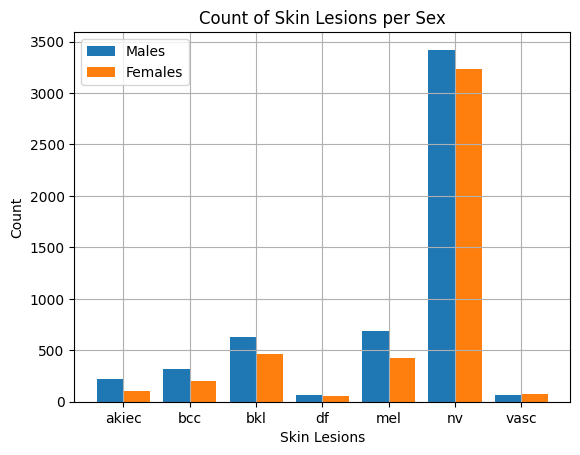

In [11]:
# Plotting Skin Lesions by Sex
sex_sl_df = meta_df.groupBy('sex', 'dx').count().orderBy(F.col('dx'))
male_sl_df = sex_sl_df.filter(sex_sl_df.sex == 'male')
fem_sl_df = sex_sl_df.filter(sex_sl_df.sex == 'female')

X = [val.__getitem__('dx') for val in male_sl_df.select('dx').collect()]
Y_male = [val.__getitem__('count') for val in male_sl_df.select('count').collect()]
Y_fem = [val.__getitem__('count') for val in fem_sl_df.select('count').collect()]

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, Y_male, 0.4, label = 'Males') 
plt.bar(X_axis + 0.2, Y_fem, 0.4, label = 'Females') 
  
plt.xticks(X_axis, X) 
plt.xlabel('Skin Lesions') 
plt.ylabel('Count') 
plt.title('Count of Skin Lesions per Sex')
plt.legend()
plt.grid(True)
plt.show() 

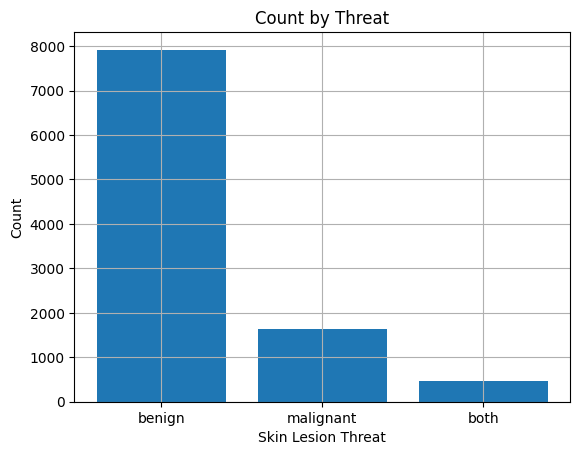

In [12]:
# Plotting by Threat
threat_df = meta_df.groupBy('threat').count().orderBy(F.col('count').desc())
X = [val.__getitem__('threat') for val in threat_df.select('threat').collect()]
Y = [val.__getitem__('count') for val in threat_df.select('count').collect()]
title = 'Count by Threat'
plot_bar(X, Y, title, 'Skin Lesion Threat', 'Count')

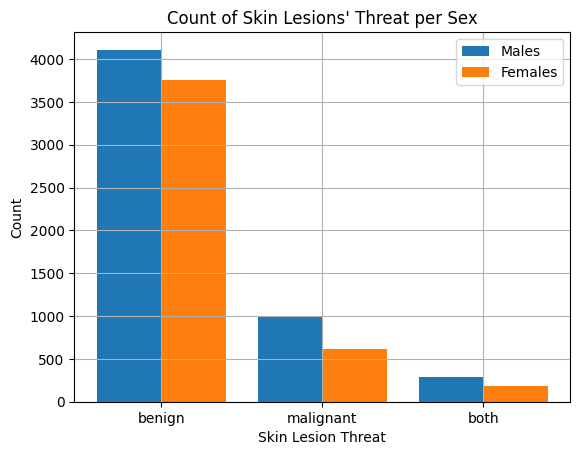

23/12/16 13:52:56 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [13]:
# Plotting Threat by Sex
# Plotting Skin Lesions by Sex
sex_threat_df = meta_df.groupBy('sex', 'threat').count().orderBy(
    F.when(F.col('threat') == 'benign', 1)
    .when(F.col('threat') == 'malignant', 2)
    .when(F.col('threat') == 'both', 3)
)
male_threat_df = sex_threat_df.filter(sex_threat_df.sex == 'male')
fem_threat_df = sex_threat_df.filter(sex_threat_df.sex == 'female')

X = [val.__getitem__('threat') for val in male_threat_df.select('threat').collect()]
Y_male = [val.__getitem__('count') for val in male_threat_df.select('count').collect()]
Y_fem = [val.__getitem__('count') for val in fem_threat_df.select('count').collect()]

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, Y_male, 0.4, label = 'Males') 
plt.bar(X_axis + 0.2, Y_fem, 0.4, label = 'Females') 
  
plt.xticks(X_axis, X) 
plt.xlabel('Skin Lesion Threat') 
plt.ylabel('Count') 
plt.title('Count of Skin Lesions\' Threat per Sex')
plt.legend()
plt.grid(True)
plt.show() 